In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt

sns.set_style('white')

DATA = '../data/'

Administrative districts lookup

In [2]:
aimag_lookup = {'UB':'Ulaanbaatar',
            'DO':'Dornod',
            'SB':"Su'xbaatar", 
            'KhE':'Xentii',
            'TU':"To'v",
            'GS':"Govisu'mber", 
            'BG':'Dornogovi',
            'DA':'Darxan-Uul',
            'DU':'Dundgovi',
            'OR':'Orxon',
            'UV':"O'vorxangai", 
            'BU':'Bulgan',
            'BKh':'Bayanxongor',
            'AR':'Arxangai',
            'KhU':"Xo'vsgol",
            'ZA':'Zavxan',
            'GA':'Govi-Altai',
            'Bay':"Bayan-O'lgii", 
            'KhO':'Xovd',
            'UG':"O'mnogovi", 
            'UVs':'Uvs',
            'SE':'Selenge'}

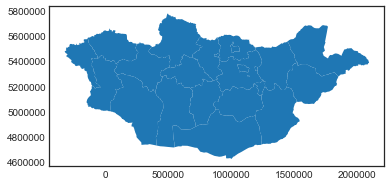

In [3]:
aimag_map = gpd.read_file(DATA+'GIS/aimag_boundaries/aimags_alagac_utm.shp').drop('NAME_L1', axis=1)
aimag_map.plot()

In [4]:
aimag_map['Province'] = aimag_map.NAME.replace({aimag_lookup[code]:code for code in aimag_lookup})

Import line list

In [5]:
line_list = pd.read_csv(DATA+'clean/line_list.csv', parse_dates=['date_onset', 'dob', 'date_lab'])

In [6]:
lab_samples = line_list.dropna(subset=['date_lab']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


Tally of clinic- and lab-confirmed cases

In [7]:
pd.crosstab(lab_samples.confirmed, lab_samples.labconfirmed)

labconfirmed,0.0,1.0
confirmed,,
0.0,1218,0
1.0,1855,4015


Lab-confirmed counts (log-transformed) mapped by province

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


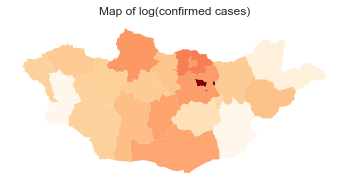

In [8]:
ax = (aimag_map.join(lab_samples.assign(NAME=lab_samples.provincecity.replace(aimag_lookup))
                 .groupby('NAME')
                 .labconfirmed.sum().apply(np.log), on='NAME')
             .plot(column='labconfirmed', cmap='OrRd'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title('Map of log(confirmed cases)');

The time from date of onset to lab confirmation

In [9]:
lab_samples['onset_to_lab'] = (lab_samples.date_lab - lab_samples.date_onset).dt.days

In [10]:
(lab_samples.onset_to_lab<0).sum()

33

Negative values for `onset_to_lab` treated as missing

In [11]:
lab_samples.loc[lab_samples.onset_to_lab<0, 'onset_to_lab'] = np.nan

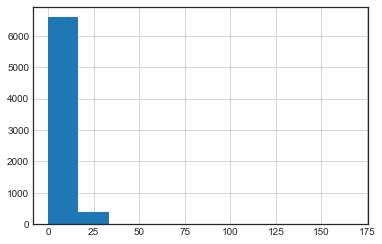

In [12]:
lab_samples.onset_to_lab.hist()

Age distribution

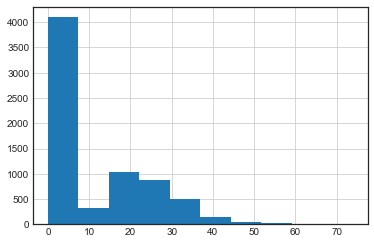

In [13]:
lab_samples.age_years.hist()

Extract clinic-confirmed cases

In [14]:
clinic_confirmed = lab_samples.query('confirmed==1')

In [15]:
clinic_confirmed.isnull().sum()

id                 0
date_onset        29
provincecity       2
dob               22
age_years         24
died               0
confirmed          0
labconfirmed       0
date_lab           0
vaccine_ever    1797
male               0
month_onset       29
year_onset        29
onset_to_lab      56
dtype: int64

### Reporting lag model

In [16]:
from pymc3 import sample, Model, invlogit, fit, generator, DensityDist, sample_ppc, find_MAP
from pymc3 import Deterministic, SVGD, GaussianRandomWalk, EllipticalSlice
from pymc3.gp import cov, Latent
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat, Binomial, Exponential, HalfNormal
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit, invlogit

import theano.tensor as tt
from theano import shared

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
lag, n, confirmed = clinic_confirmed.groupby('onset_to_lab').labconfirmed.agg(['count', 'sum']).reset_index().values.T

In [18]:
clinic_confirmed.groupby('onset_to_lab').labconfirmed.agg(['count', 'sum']).reset_index().head()

,onset_to_lab,count,sum
0,0.0,31,23.0
1,1.0,109,60.0
2,2.0,446,273.0
3,3.0,705,437.0
4,4.0,891,574.0


In [19]:
with Model() as lag_model:
    
    ρ = Exponential('ρ', 1)
    η = Exponential('η', 1)
    
    K = η**2 * cov.ExpQuad(1, ρ)
    gp = Latent(cov_func=K)
    f = gp.prior('f', X=lag[:, None])
    
    π = Deterministic('π', invlogit(f))
    
    confirmation = Binomial('confirmation', p=π, n=n.astype(int), observed=confirmed.astype(int))

In [21]:
with lag_model:
    lag_approx = fit(30000)
    lag_trace = lag_approx.sample(1000)
#     lag_trace = sample(1000, tune=2000)


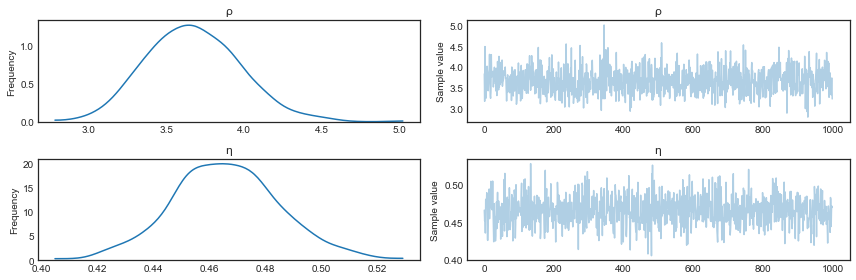

In [22]:
traceplot(lag_trace, varnames=['ρ', 'η']);

In [23]:
lag_data = pd.DataFrame({'lag': lag,
                        'obs': confirmed})

In [24]:
lag_grid = np.linspace(0, 160, 200)[:,None]

# add the GP conditional to the model, given the new X values
with lag_model:
    f_pred = gp.conditional("f_pred", lag_grid)

In [25]:
with lag_model:
    y_pred = sample_ppc(lag_trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:10<00:00, 96.09it/s]


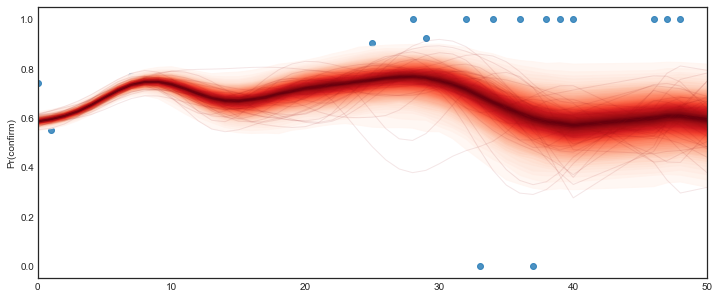

In [26]:
from pymc3.gp.util import plot_gp_dist

plt.figure(figsize=(12,5))
ax = sns.regplot(lag, confirmed/n, fit_reg=False)

plot_gp_dist(ax, 1/(1+np.exp(-lag_trace["f"])), lag[:, None])
ax.set_xlim(0,50)
ax.set_ylabel('Pr(confirm)');

### Age model

In [27]:
age_data = clinic_confirmed.dropna(subset=['age_years']).copy()

In [28]:
age_data['age_months'] = (age_data.age_years*12).astype('int')

In [29]:
age_data.loc[:, 'age_years'] = age_data.age_years.astype(int)

In [30]:
age, n, confirmed = age_data.groupby('age_months').labconfirmed.agg(['count', 'sum']).reset_index().values.T

In [31]:
age_data.groupby('age_months').labconfirmed.agg(['count', 'sum'])

,count,sum
age_months,,
0,42,27.0
1,101,66.0
2,122,105.0
3,195,144.0
4,288,216.0
5,387,290.0
6,420,328.0
7,379,298.0
8,369,304.0


In [ ]:
with Model() as age_model:
    
    ϕ = Gamma('ϕ', 1, 1)
    β = Exponential('β', 1)
    
    K = β**2 * cov.ExpQuad(1, ϕ)
    gp = Latent(cov_func=K)
    g = gp.prior('g', X=age[:, None])
    
    σ = HalfNormal('σ', 3, testval=0.1)
    noise = Latent(cov_func=cov.WhiteNoise(σ))
    f = noise.prior('f', X=age[:, None])
    
    θ = Deterministic('θ', invlogit(g + f))
    
    confirmation_age = Binomial('confirmation_age', p=θ, n=n.astype(int), observed=confirmed.astype(int))

In [ ]:
with age_model:
#     mp = find_MAP(include_transformed=True)
    approx = fit(20000)
    trace_age = approx.sample(1000)

Average Loss = 1,157.6:  14%|█▎        | 2718/20000 [05:30<41:17,  6.98it/s]  

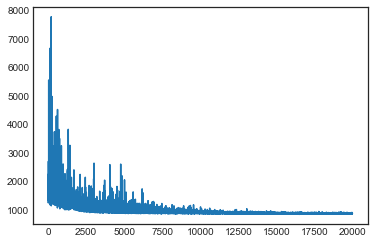

In [38]:
plt.plot(approx.hist)

In [68]:
# with age_model:
#     trace_age = sample(1000, tune=2000, chains=1) 

In [36]:
predictions = pd.DataFrame({'age': age,
                            'obs': confirmed})

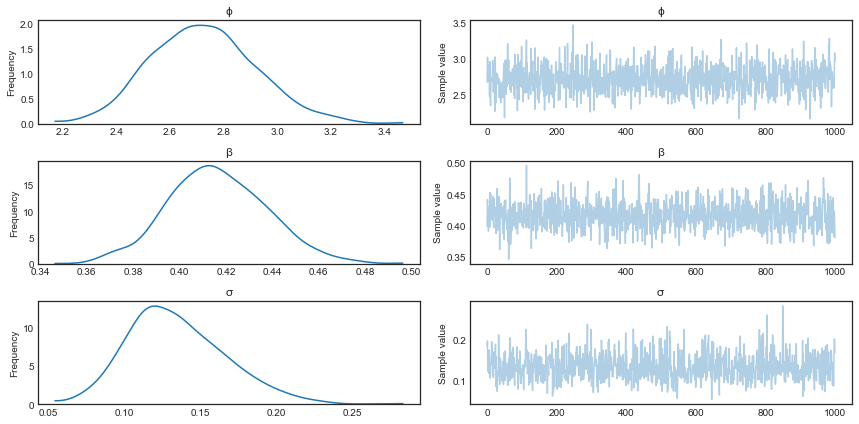

In [37]:
traceplot(trace_age, varnames=['ϕ', 'β', 'σ']);

In [39]:
age_grid = np.linspace(0, 75, 200)[:,None]

# add the GP conditional to the model, given the new X values
with age_model:
    g_pred = gp.conditional("g_pred", age_grid)

In [40]:
with age_model:
    y_pred = sample_ppc(trace_age, vars=[g_pred], samples=1000)

100%|██████████| 1000/1000 [00:42<00:00, 23.28it/s]


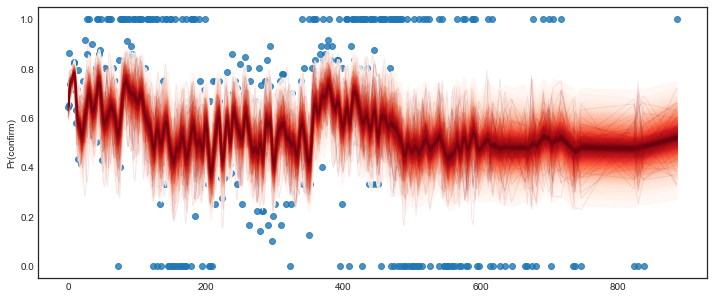

In [41]:
from pymc3.gp.util import plot_gp_dist

plt.figure(figsize=(12,5))
ax = sns.regplot(age, confirmed/n, fit_reg=False)

plot_gp_dist(ax, 1/(1+np.exp(-trace_age["g"])), age[:, None])
ax.set_ylabel('Pr(confirm)');

## Combined model

In [53]:
age, lag, n, confirmed = (age_data.groupby(['age_years', 'onset_to_lab'])
                              .labconfirmed.agg(['count', 'sum']).reset_index().values.T)

In [54]:
X = np.c_[age, lag]

In [56]:
with Model() as combined_model:
    
    ρ = Exponential('ρ', 1, shape=(2,))
    η = Exponential('η', 1)
    
    K = η**2 * cov.ExpQuad(2, ρ)
    gp = Latent(cov_func=K)
    f = gp.prior('f', X=X)
    
    π = Deterministic('π', invlogit(f))
    
    confirmation = Binomial('confirmation', p=π, n=n.astype(int), observed=confirmed.astype(int))

In [57]:
with combined_model:
    
    approx_combined = fit(20000)

Average Loss = 1,703.2:   5%|▍         | 985/20000 [03:22<1:10:17,  4.51it/s]
Interrupted at 985 [4%]: Average Loss = 1,536.3
